# Assignemnt3 Stock Price Prediction

In [23]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from torch.optim import Adam, RMSprop

In [24]:
file_path = 'apple_stock.csv'
df = pd.read_csv(file_path)

# Convert the 'Date' column to datetime format and sort the dataframe by date
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')
df.set_index('Date', inplace=True)

# Extract the 'Close' prices into a numpy array
prices = df[['Close']].values

# Scale the price data to the range [0, 1]
scaler = MinMaxScaler()
scaled_prices = scaler.fit_transform(prices)

# Function to create sequences from the dataset for the model to train on
def create_sequences(data, seq_length=30):
    X = []
    y = []
    for i in range(len(data)-seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 30
X, y = create_sequences(scaled_prices, seq_length=seq_length)  # X shape: (N,30,1), y shape: (N,1)


In [25]:
print("Total data length:", len(X))

Total data length: 2445


In [26]:
# Split the dataset into training, validation, and test sets
train_size = int(0.7 * len(X))+1
val_size = int(0.20 * len(X))+2
test_size = len(X) - train_size - val_size

X_train = X[:train_size]
y_train = y[:train_size]

X_val = X[train_size:train_size+val_size]
y_val = y[train_size:train_size+val_size]

X_test = X[train_size+val_size:]
y_test = y[train_size+val_size:]

# Convert numpy arrays to PyTorch tensors
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32)

X_val_t = torch.tensor(X_val, dtype=torch.float32)
y_val_t = torch.tensor(y_val, dtype=torch.float32)

X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_test_t = torch.tensor(y_test, dtype=torch.float32)

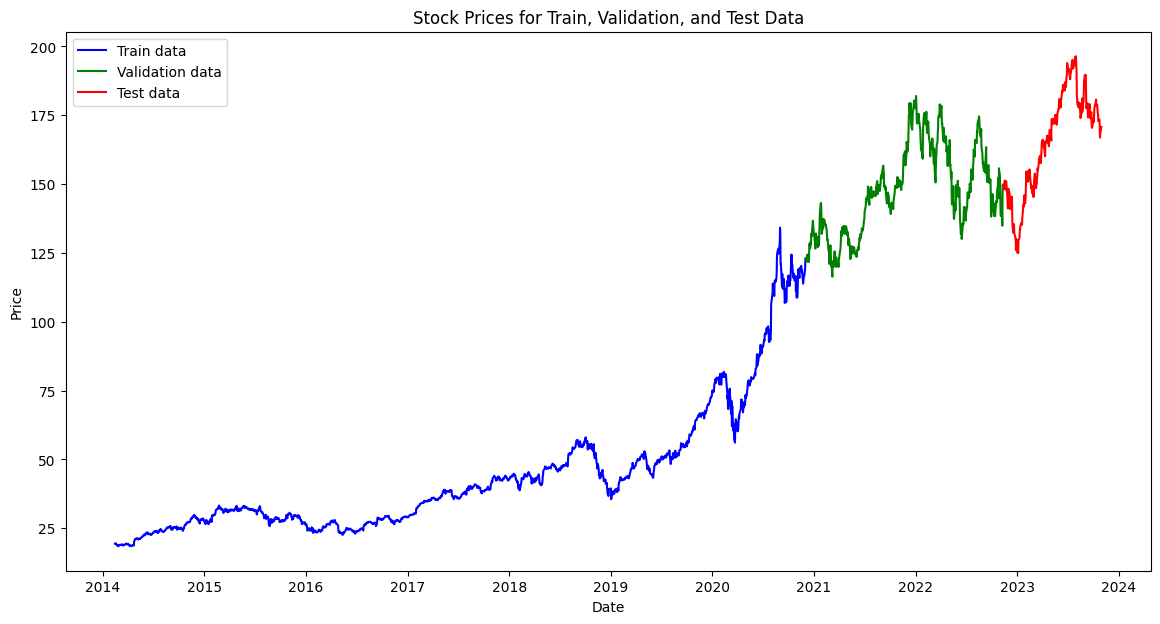

In [27]:
# Inverse transform the scaled prices to original prices for visualization
prices_train = scaler.inverse_transform(y_train)
prices_val = scaler.inverse_transform(y_val)
prices_test = scaler.inverse_transform(y_test)

# Retrieve date indices to align with the training, validation, and test sets
dates = df.index
train_dates = dates[seq_length:train_size+seq_length]
val_dates = dates[train_size+seq_length:train_size+val_size+seq_length]
test_dates = dates[train_size+val_size+seq_length:]

# Plot the training, validation, and test data with respective dates
plt.figure(figsize=(14, 7))
plt.plot(train_dates, prices_train, color='blue', label='Train data')
plt.plot(val_dates, prices_val, color='green', label='Validation data')
plt.plot(test_dates, prices_test, color='red', label='Test data')

plt.title('Stock Prices for Train, Validation, and Test Data')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [28]:
batch_size = 64

# Define a custom PyTorch dataset for time series data
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
# Create dataset objects for each set
train_dataset = TimeSeriesDataset(X_train_t, y_train_t)
val_dataset = TimeSeriesDataset(X_val_t, y_val_t)
test_dataset = TimeSeriesDataset(X_test_t, y_test_t)
# Create data loaders to handle batching of data
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [29]:
input_dim = 1
output_dim = 1

# Define an RNN model class
class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(RNNModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # x: (batch, seq, input_dim)  Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        # Forward propagate the RNN
        out, _ = self.rnn(x, h0)
        # out: (batch, seq, hidden_dim) Transform the output to the desired output dimension
        out = self.fc(out[:, -1, :])  # Taking the last timestep
        return out


In [30]:
# Define an LSTM model class
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out
# Define a GRU model class
class GRUModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(GRUModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        out, _ = self.gru(x, h0)
        out = self.fc(out[:, -1, :])
        return out

In [31]:
# Define a Bi-directional RNN model class
class BiRNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(BiRNNModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_dim, hidden_dim, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim*2, output_dim)

    def forward(self, x):
        # x: (batch, seq, input_dim)
        h0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_dim).to(x.device)  # 双向层数= num_layers*2
        out, _ = self.rnn(x, h0)
        # out: (batch, seq, hidden_dim*2) 因为是双向
        out = self.fc(out[:, -1, :])  # 取最后一个时间步的输出特征
        return out
# Define a Bi-directional LSTM model class
class BiLSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(BiLSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim*2, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_dim).to(x.device)  # 双向 * 2
        c0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_dim).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out
# Define a Bi-directional GRU model class
class BiGRUModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(BiGRUModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim*2, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_dim).to(x.device)
        out, _ = self.gru(x, h0)
        out = self.fc(out[:, -1, :])
        return out

In [32]:
class CNNLSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim, cnn_out_channels=32, kernel_size=1):
        super(CNNLSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        # CNN部分: Conv1d expects input as (batch, channels_in, seq_length)
        self.conv = nn.Conv1d(in_channels=input_dim, out_channels=cnn_out_channels, kernel_size=kernel_size, padding=0)

        # LSTM部分(单向)
        self.lstm = nn.LSTM(cnn_out_channels, hidden_dim, num_layers, batch_first=True)

        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # x: (batch, seq_length, input_dim) --> 如 (batch,10,6)
        # 转置为Conv1d要求格式: (batch, input_dim, seq_length) = (batch, 6, 10)
        x = x.permute(0, 2, 1)
        # 卷积后 (batch, cnn_out_channels, new_seq_length)
        # kernel_size=1时, new_seq_length = seq_length = 10
        x = self.conv(x) # (batch, 32, 10)

        # 转回LSTM输入格式: (batch, seq_length, features) = (batch,10,32)
        x = x.permute(0, 2, 1)

        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)

        out, _ = self.lstm(x, (h0, c0))  # out:(batch, 10, hidden_dim)
        out = out[:, -1, :] # 取最后时间步
        out = self.fc(out)  # (batch, output_dim)
        return out


class CNNGRUModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim, cnn_out_channels=32, kernel_size=1):
        super(CNNGRUModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.conv = nn.Conv1d(in_channels=input_dim, out_channels=cnn_out_channels, kernel_size=kernel_size, padding=0)

        self.gru = nn.GRU(cnn_out_channels, hidden_dim, num_layers, batch_first=True)

        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # x: (batch, 10, 6)
        x = x.permute(0, 2, 1) # (batch,6,10)
        x = self.conv(x)       # (batch,32,10)
        x = x.permute(0, 2, 1) # (batch,10,32)

        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)

        out, _ = self.gru(x, h0)  # out:(batch,10,hidden_dim)
        out = out[:, -1, :]
        out = self.fc(out)
        return out


In [33]:
class CNNBiLSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim, cnn_out_channels=32, kernel_size=1):
        super(CNNBiLSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.conv = nn.Conv1d(in_channels=input_dim, out_channels=cnn_out_channels, kernel_size=kernel_size, padding=0)

        self.lstm = nn.LSTM(cnn_out_channels, hidden_dim, num_layers, batch_first=True, bidirectional=True)

        self.fc = nn.Linear(hidden_dim*2, output_dim)

    def forward(self, x):
        # x:(batch,10,6)
        x = x.permute(0, 2, 1) # (batch,6,10)
        x = self.conv(x)       # (batch,32,10)
        x = x.permute(0, 2, 1) # (batch,10,32)

        h0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_dim).to(x.device)

        out, _ = self.lstm(x, (h0, c0)) # out:(batch,10,hidden_dim*2)
        out = out[:, -1, :]
        out = self.fc(out)
        return out



class CNNBiGRUModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim, cnn_out_channels=32, kernel_size=1):
        super(CNNBiGRUModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.conv = nn.Conv1d(in_channels=input_dim, out_channels=cnn_out_channels, kernel_size=kernel_size, padding=0)

        self.gru = nn.GRU(cnn_out_channels, hidden_dim, num_layers, batch_first=True, bidirectional=True)

        self.fc = nn.Linear(hidden_dim*2, output_dim)

    def forward(self, x):
        # x:(batch,10,6)
        x = x.permute(0, 2, 1) # (batch,6,10)
        x = self.conv(x)       # (batch,32,10)
        x = x.permute(0, 2, 1) # (batch,10,32)

        h0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_dim).to(x.device)

        out, _ = self.gru(x, h0) # out:(batch,10,hidden_dim*2)
        out = out[:, -1, :]
        out = self.fc(out)
        return out

import torch
import torch.nn as nn

class CNNBiRNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim, cnn_out_channels=32, kernel_size=1):
        super(CNNBiRNNModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        # CNN部分: Conv1d expects input as (batch, channels_in, seq_length)
        self.conv = nn.Conv1d(in_channels=input_dim, out_channels=cnn_out_channels, kernel_size=kernel_size, padding=0)

        # 双向RNN部分
        self.rnn = nn.RNN(cnn_out_channels, hidden_dim, num_layers, batch_first=True, bidirectional=True)

        # Fully connected layer to transform the output to the desired output dimension
        self.fc = nn.Linear(hidden_dim*2, output_dim)  # Multiply hidden_dim by 2 for bidirectional

    def forward(self, x):
        # x: (batch, seq_length, input_dim) --> e.g., (batch, 10, 6)
        # 转换为Conv1d要求的格式: (batch, input_dim, seq_length) = (batch, 6, 10)
        x = x.permute(0, 2, 1)
        # 卷积后 (batch, cnn_out_channels, new_seq_length)
        # kernel_size=1时, new_seq_length = seq_length = 10
        x = self.conv(x) # (batch, 32, 10)

        # 转回RNN输入格式: (batch, seq_length, features) = (batch, 10, 32)
        x = x.permute(0, 2, 1)

        # 初始化隐藏状态
        h0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_dim).to(x.device)  # 双向因此 *2

        # RNN输出
        out, _ = self.rnn(x, h0)  # out:(batch, seq_length, hidden_dim*2)

        # 取最后一个时间步的输出
        out = out[:, -1, :]

        # Fully connected layer
        out = self.fc(out)
        return out


In [34]:
# function to train and evaluate the model
def train_and_evaluate(train_loader, val_loader, model, criterion, optimizer, scaler, epochs=200, early_stop_patience=40, device='cpu'):
    model.to(device)
    best_val_mse = float('inf')
    final_train_mse = float('inf')
    best_model_state = None
    patience_counter = 0
    train_mse_list = []
    val_mse_list = []
    final_epoch = 0
    # Train the model using the provided training data loader.
    for epoch in range(epochs):
        model.train() # Set model to training mode
        train_losses = []
        for X_batch, y_batch in train_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())

        train_mse = np.mean(train_losses)

        # Evaluate the model on the validation set to monitor performance and apply early stopping if needed.
        model.eval() # Set model to evaluation mode
        val_losses = []
        val_preds = []
        val_trues = []
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)
                output = model(X_batch)
                loss = criterion(output, y_batch)
                val_losses.append(loss.item())

                # Collect predictions and actuals for further metrics evaluation
                val_preds.append(output.cpu().numpy())
                val_trues.append(y_batch.cpu().numpy())

        val_mse = np.mean(val_losses)

        # Record MSE for training and validation for this epoch
        train_mse_list.append(train_mse)
        val_mse_list.append(val_mse)

        # Early stopping
        if val_mse < best_val_mse:
            best_val_mse = val_mse
            final_train_mse = train_mse
            best_model_state = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= early_stop_patience:
                final_epoch = epoch + 1
                print(f"Early stopping at epoch {final_epoch}")
                break
        final_epoch = epoch + 1

    # Load the best model state for final evaluation
    model.load_state_dict(best_model_state)
    model.eval()

    # Recompute validation predictions for detailed metrics calculation
    val_preds = []
    val_trues = []
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            output = model(X_batch)
            val_preds.append(output.cpu().numpy())
            val_trues.append(y_batch.cpu().numpy())

    val_preds = np.concatenate(val_preds, axis=0)
    val_trues = np.concatenate(val_trues, axis=0)

    # Inverse scale predictions and actuals for true value comparison
    val_preds_denorm = scaler.inverse_transform(val_preds)
    val_trues_denorm = scaler.inverse_transform(val_trues)

    # Calculate Mean Absolute Percentage Error (MAPE)
    mape = np.mean(np.abs((val_trues_denorm - val_preds_denorm) / val_trues_denorm)) * 100

    # Calculate coefficient of determination (R²)
    ss_res = np.sum((val_trues_denorm - val_preds_denorm)**2)
    ss_tot = np.sum((val_trues_denorm - np.mean(val_trues_denorm))**2)
    r2 = 1 - (ss_res / ss_tot)

    # Returns the best model based on validation performance along with training and validation loss history.
    return model, final_train_mse, best_val_mse, final_epoch, train_mse_list, val_mse_list, mape, r2

In [35]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.MSELoss()

## Baseline

In [65]:
# baseline_params = {
#     'hidden_dim': 32,
#     'num_layers': 2,
#     'optimizer_class': Adam,
#     'lr': 0.001,
# }

In [66]:
# def train_baseline(model_class, model_name, scaler):
#     model = model_class(input_dim, baseline_params['hidden_dim'], baseline_params['num_layers'], output_dim).to(device)
#     optimizer = baseline_params['optimizer_class'](model.parameters(), lr=baseline_params['lr'])

#     # 修改点：train_and_evaluate现在返回8个值，需要加入scaler参数
#     trained_model, train_mse, val_mse, final_epoch, train_mse_list, val_mse_list, val_mape, val_r2 = train_and_evaluate(
#         train_loader, val_loader, model, criterion, optimizer, scaler, epochs=200, early_stop_patience=40, device=device
#     )
#     print(f"Baseline {model_name}: final_epoch={final_epoch}, train_mse={train_mse:.5f}, val_mse={val_mse:.5f}, val_mape={val_mape:.2f}%, val_r2={val_r2:.4f}")

#     # Plot train/val MSE vs epoch
#     plt.figure(figsize=(6, 6))
#     plt.plot(range(1, final_epoch+1), train_mse_list[:final_epoch], label='Train MSE')
#     plt.plot(range(1, final_epoch+1), val_mse_list[:final_epoch], label='Val MSE')
#     plt.xlabel('Epoch')
#     plt.ylabel('MSE')
#     plt.title(f'{model_name} Baseline Training Curve')
#     plt.legend()
#     plt.show()

#     # 在验证集上预测并画图
#     trained_model.eval()
#     val_preds = []
#     with torch.no_grad():
#         for i in range(len(X_val_t)):
#             X_input = X_val_t[i].unsqueeze(0).to(device)
#             pred = trained_model(X_input).cpu().numpy()
#             val_preds.append(pred[0][0])  # scalar

#     val_preds = np.array(val_preds).reshape(-1,1)
#     val_preds_inv = scaler.inverse_transform(val_preds)

#     plt.figure()
#     plt.plot(val_dates, prices_val, label='Val Actual Prices', color='red')
#     plt.plot(val_dates, val_preds_inv, label=f'Val Predicted Prices ({model_name})', color='blue')
#     plt.xlabel('Date')
#     plt.ylabel('Price')
#     plt.title(f'{model_name} Baseline Prediction on Val Set')
#     plt.legend()
#     plt.xticks(rotation=45)
#     plt.show()

#     return trained_model

Early stopping at epoch 169
Baseline RNN: final_epoch=169, train_mse=0.00054, val_mse=0.00029, val_mape=1.70%, val_r2=0.9608


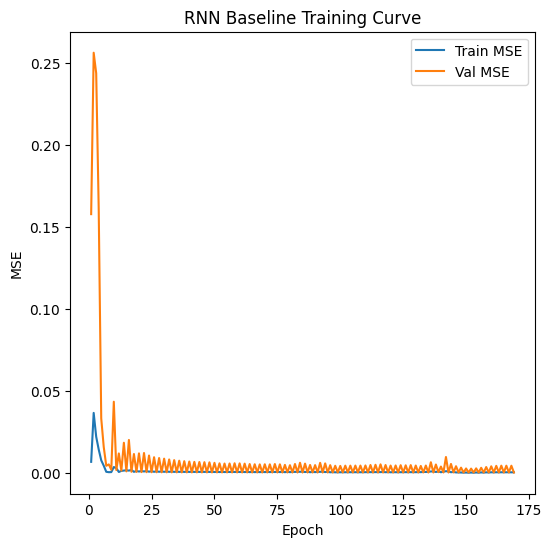

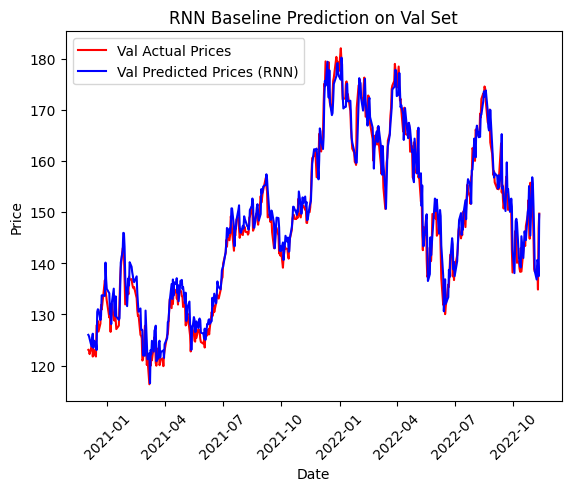

In [67]:
# rnn_baseline = train_baseline(RNNModel, "RNN",scaler)

In [68]:
# Define a dictionary mapping model names to their corresponding class implementations
models_dict = {
    "RNN": RNNModel,
    "LSTM": LSTMModel,
    "GRU": GRUModel,
    "Bi-RNN": BiRNNModel,
    "Bi-LSTM": BiLSTMModel,
    "Bi-GRU": BiGRUModel,
    "CNN-BiRNN": CNNBiRNNModel,
    "CNN-BiLSTM": CNNBiLSTMModel,
    "CNN-BiGRU": CNNBiGRUModel
}
# Baseline parameters for all models
same_params = {
    'hidden_dim': 32,
    'num_layers': 2,
    'optimizer_class': Adam,
    'lr': 0.001,
}

In [69]:
# Function to train a single model, inputting model class and returning training and evaluation metrics
def train_one_model(model_class, model_name, scaler):
    model = model_class(input_dim, same_params['hidden_dim'], same_params['num_layers'], output_dim).to(device)
    optimizer = same_params['optimizer_class'](model.parameters(), lr=same_params['lr'])

    trained_model, train_mse, val_mse, final_epoch, train_mse_list, val_mse_list, val_mape, val_r2 = train_and_evaluate(
        train_loader, val_loader, model, criterion, optimizer, scaler, epochs=200, early_stop_patience=40, device=device
    )
    return {
        'model': model_name,
        'lr': same_params['lr'],
        'optimizer': same_params['optimizer_class'].__name__,
        'hidden_dim': same_params['hidden_dim'],
        'num_layers': same_params['num_layers'],
        'epoch': final_epoch,
        'train_mse': train_mse,
        'val_mse': val_mse,
        'train_mse_list': train_mse_list,
        'val_mse_list': val_mse_list,
        'trained_model': trained_model,
        'val_mape': val_mape,
        'val_r2': val_r2
    }

# Iterate over each model class, train, and log results
all_results = []
for model_name, model_class in models_dict.items():
    print(f"Training {model_name} with same parameters ...")
    res = train_one_model(model_class, model_name, scaler)
    all_results.append(res)

Training RNN with same parameters ...
Early stopping at epoch 184
Training LSTM with same parameters ...
Early stopping at epoch 55
Training GRU with same parameters ...
Training Bi-RNN with same parameters ...
Early stopping at epoch 160
Training Bi-LSTM with same parameters ...
Training Bi-GRU with same parameters ...
Early stopping at epoch 140
Training CNN-BiRNN with same parameters ...
Early stopping at epoch 77
Training CNN-BiLSTM with same parameters ...
Early stopping at epoch 110
Training CNN-BiGRU with same parameters ...
Early stopping at epoch 90


In [70]:
df_results = pd.DataFrame([{k:v for k,v in r.items() if k not in ['train_mse_list','val_mse_list','trained_model']} for r in all_results])
df_results

,model,lr,optimizer,hidden_dim,num_layers,epoch,train_mse,val_mse,val_mape,val_r2
0,RNN,0.001,Adam,32,2,184,0.000323,0.000330,1.696458,0.958050
1,LSTM,0.001,Adam,32,2,55,0.001097,0.001576,12.799406,-0.680430
2,GRU,0.001,Adam,32,2,200,0.000567,0.000279,1.532323,0.965493
3,Bi-RNN,0.001,Adam,32,2,160,0.000231,0.000286,1.543851,0.963815
4,Bi-LSTM,0.001,Adam,32,2,200,0.000342,0.000325,1.692906,0.960752
5,Bi-GRU,0.001,Adam,32,2,140,0.000814,0.000300,1.904036,0.953655
6,CNN-BiRNN,0.001,Adam,32,2,77,0.001457,0.001002,3.649342,0.801655
7,CNN-BiLSTM,0.001,Adam,32,2,110,0.000880,0.004217,5.778471,0.445252
8,CNN-BiGRU,0.001,Adam,32,2,90,0.001208,0.000317,3.568820,0.792523


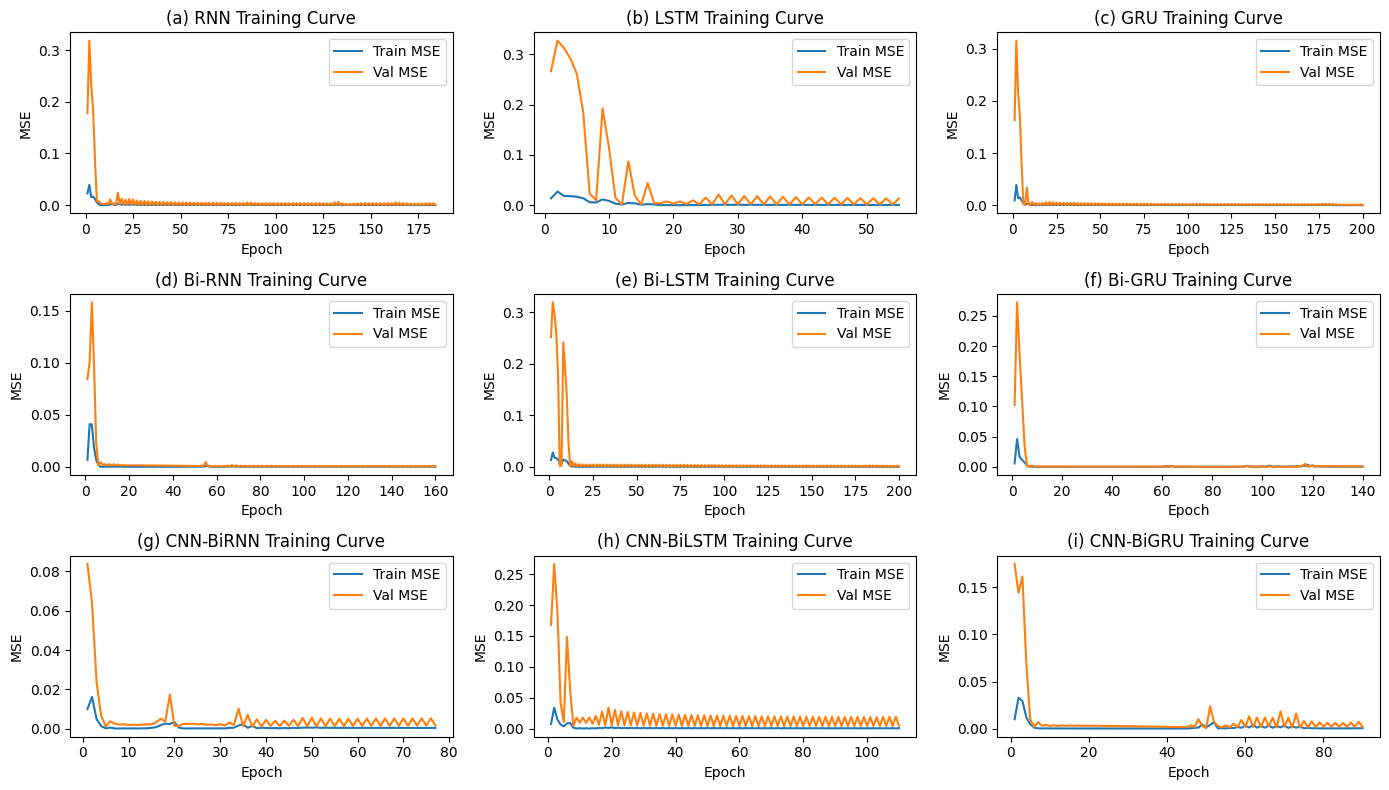

In [71]:
# Visualize training and validation MSE over epochs for each model
fig, axes = plt.subplots(3, 3, figsize=(14, 8))
axes = axes.flatten()
for i, r in enumerate(all_results):
    final_epoch = r['epoch']
    train_mse_list = r['train_mse_list'][:final_epoch]
    val_mse_list = r['val_mse_list'][:final_epoch]
    prefix = f"({chr(97+i)}) "
    axes[i].plot(range(1, final_epoch+1), train_mse_list, label='Train MSE')
    axes[i].plot(range(1, final_epoch+1), val_mse_list, label='Val MSE')
    axes[i].set_xlabel('Epoch')
    axes[i].set_ylabel('MSE')
    axes[i].set_title(prefix + f'{r["model"]} Training Curve')
    axes[i].legend()

plt.tight_layout()
plt.show()

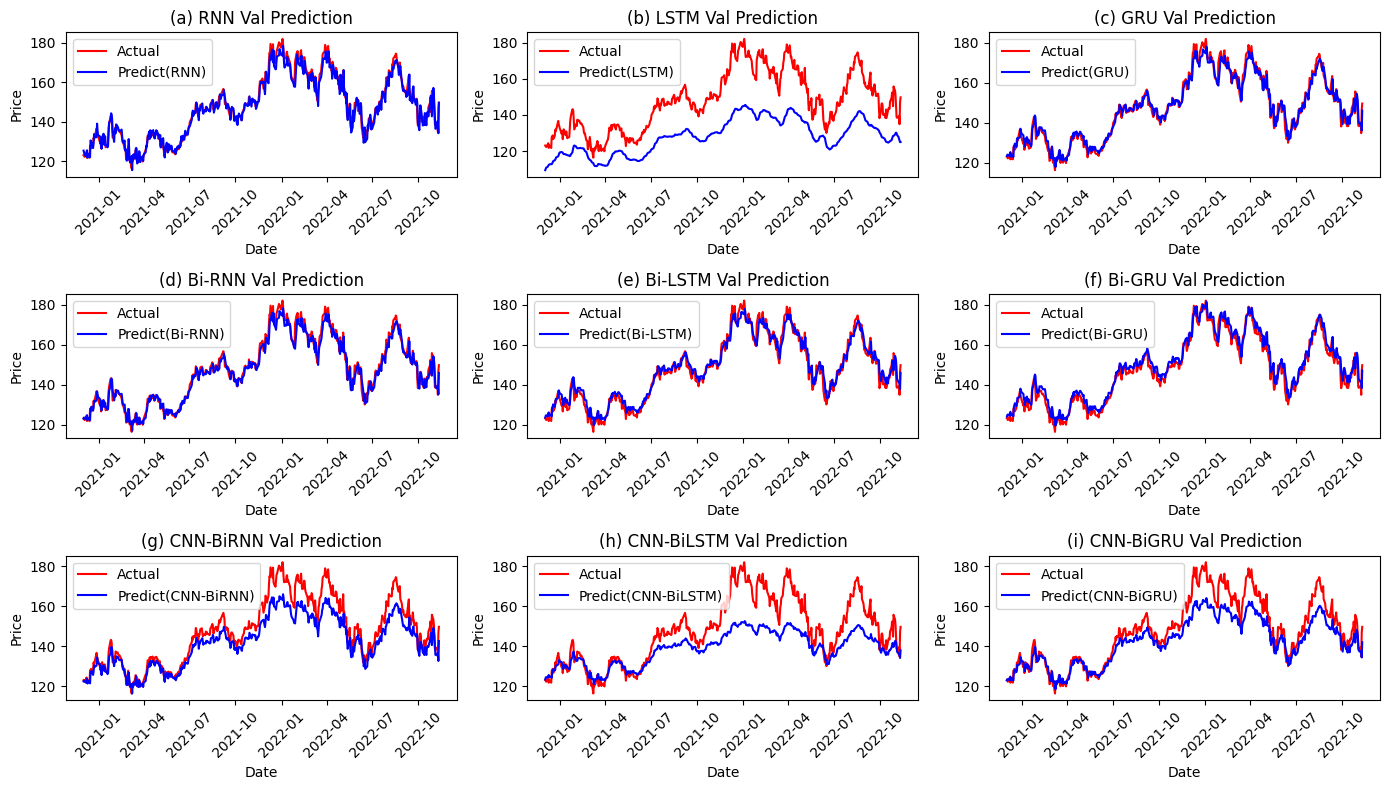

In [72]:
fig, axes = plt.subplots(3, 3, figsize=(14, 8))
axes = axes.flatten()
for i, r in enumerate(all_results):
    model_name = r['model']
    trained_model = r['trained_model']
    trained_model.eval()
    val_preds = []
    with torch.no_grad():
        for j in range(len(X_val_t)):
            X_input = X_val_t[j].unsqueeze(0).to(device)
            pred = trained_model(X_input).cpu().numpy()
            val_preds.append(pred[0][0])
    val_preds = np.array(val_preds).reshape(-1,1)
    val_preds_inv = scaler.inverse_transform(val_preds)

    prefix = f"({chr(97+i)}) "
    axes[i].plot(val_dates, prices_val, label='Actual', color='red')
    axes[i].plot(val_dates, val_preds_inv, label=f'Predict({model_name})', color='blue')
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel('Price')
    axes[i].set_title(prefix + f'{model_name} Val Prediction')
    axes[i].legend()
    for tick in axes[i].get_xticklabels():
        tick.set_rotation(45)

plt.tight_layout()
plt.show()

## hyperparams tuning

In [44]:
# Define the space for hyperparameter search
hyperparams_space = {
    'lr': [0.0001, 0.001, 0.01],
    'optimiser': [Adam, RMSprop],
    'hidden_dim': [32, 64, 128],
    'num_layers': [1, 2, 3, 4]
}

In [45]:
# Perform hyperparameter search for each model class
from itertools import product
def hyperparam_search(model_class, model_name, input_dim, output_dim, train_loader, val_loader, device, criterion, scaler, hyperparams_space):
    results = []
    best_model = None
    best_val_mse = float('inf')
    best_params = None
    best_train_mse = None
    best_epoch = None
    best_mape = None
    best_r2 = None
    # Iterate through all possible combinations of hyperparameters
    for lr, opt_class, hidden_dim, num_layers in product(hyperparams_space['lr'],
                                                         hyperparams_space['optimiser'],
                                                         hyperparams_space['hidden_dim'],
                                                         hyperparams_space['num_layers']):
        model = model_class(input_dim, hidden_dim, num_layers, output_dim).to(device)
        optimizer = opt_class(model.parameters(), lr=lr)

        trained_model, final_train_mse, val_mse, final_epoch, _, _, val_mape, val_r2 = train_and_evaluate(
            train_loader, val_loader, model, criterion, optimizer, scaler, epochs=200, early_stop_patience=40, device=device
        )
        # Train and evaluate model
        results.append({
            'model': model_name,
            'lr': lr,
            'optimizer': opt_class.__name__,
            'hidden_dim': hidden_dim,
            'num_layers': num_layers,
            'epoch': final_epoch,
            'train_mse': final_train_mse,
            'val_mse': val_mse,
            'val_mape': val_mape,
            'val_r2': val_r2
        })
        # Update the best model if found a new best
        if val_mse < best_val_mse:
            best_val_mse = val_mse
            best_model = trained_model
            best_params = (lr, opt_class, hidden_dim, num_layers)
            best_train_mse = final_train_mse
            best_epoch = final_epoch
            best_mape = val_mape
            best_r2 = val_r2

    return best_model, best_train_mse, best_val_mse, best_params, results, best_mape, best_r2

In [46]:
models_dict = {
    "RNN": RNNModel,
    "LSTM": LSTMModel,
    "GRU": GRUModel,
    "Bi-RNN": BiRNNModel,
    "Bi-LSTM": BiLSTMModel,
    "Bi-GRU": BiGRUModel,
    "CNN-BiRNN": CNNBiRNNModel,
    "CNN-BiLSTM": CNNBiLSTMModel,
    "CNN-BiGRU": CNNBiGRUModel
}

all_model_best_results = []
all_results = []

# Iterate over all models to perform hyperparameter search and store results
for model_name, model_class in models_dict.items():
    print(f"=== Hyperparameter Search for {model_name} ===")
    best_model, best_train_mse, best_val_mse, best_params, results, best_mape, best_r2 = hyperparam_search(
        model_class, model_name, input_dim, output_dim, train_loader, val_loader, device, criterion, scaler, hyperparams_space
    )
    print(f"Best {model_name} Params:", best_params, "Val MSE:", best_val_mse, "Train MSE:", best_train_mse, f"Val MAPE: {best_mape:.2f}%", f"Val R2: {best_r2:.4f}")

    # Store all results for analysis
    all_results.extend(results)

    # Save best results for each model
    all_model_best_results.append({
        'model_name': model_name,
        'best_model': best_model,
        'best_val_mse': best_val_mse,
        'best_mape': best_mape,
        'best_r2': best_r2
    })

=== Hyperparameter Search for RNN ===
Early stopping at epoch 54
Early stopping at epoch 75
Early stopping at epoch 58
Early stopping at epoch 97
Early stopping at epoch 66
Early stopping at epoch 54
Early stopping at epoch 50
Early stopping at epoch 57
Early stopping at epoch 51
Early stopping at epoch 45
Early stopping at epoch 45
Early stopping at epoch 121
Early stopping at epoch 152
Early stopping at epoch 161
Early stopping at epoch 57
Early stopping at epoch 115
Early stopping at epoch 82
Early stopping at epoch 92
Early stopping at epoch 61
Early stopping at epoch 67
Early stopping at epoch 61
Early stopping at epoch 79
Early stopping at epoch 45
Early stopping at epoch 44
Early stopping at epoch 44
Early stopping at epoch 57
Early stopping at epoch 45
Early stopping at epoch 45
Early stopping at epoch 46
Early stopping at epoch 100
Early stopping at epoch 52
Early stopping at epoch 43
Early stopping at epoch 66
Early stopping at epoch 44
Early stopping at epoch 46
Early stoppi

In [47]:
# Create a DataFrame to analyze all results
df_all = pd.DataFrame(all_results)
df_all_sorted = df_all.sort_values('val_mse')
display(df_all_sorted.head(30))

,model,lr,optimizer,hidden_dim,num_layers,epoch,train_mse,val_mse,val_mape,val_r2
272,Bi-RNN,0.0100,Adam,128,1,54,0.000043,0.000264,2.201605,0.942025
336,Bi-LSTM,0.0100,Adam,32,1,80,0.000071,0.000264,1.563897,0.962944
464,CNN-BiRNN,0.0010,Adam,128,1,49,0.000044,0.000265,1.458138,0.968178
608,CNN-BiGRU,0.0010,Adam,128,1,115,0.000046,0.000265,1.566016,0.963926
268,Bi-RNN,0.0100,Adam,64,1,58,0.000198,0.000265,5.938878,0.672798
344,Bi-LSTM,0.0100,Adam,128,1,84,0.000185,0.000266,13.466547,-0.775824
249,Bi-RNN,0.0010,Adam,128,2,71,0.000047,0.000267,16.697721,-2.569501
340,Bi-LSTM,0.0100,Adam,64,1,54,0.000294,0.000267,11.695172,-0.300038
388,Bi-GRU,0.0010,Adam,64,1,200,0.000084,0.000267,1.494775,0.967329
241,Bi-RNN,0.0010,Adam,32,2,134,0.000227,0.000268,1.487585,0.967156


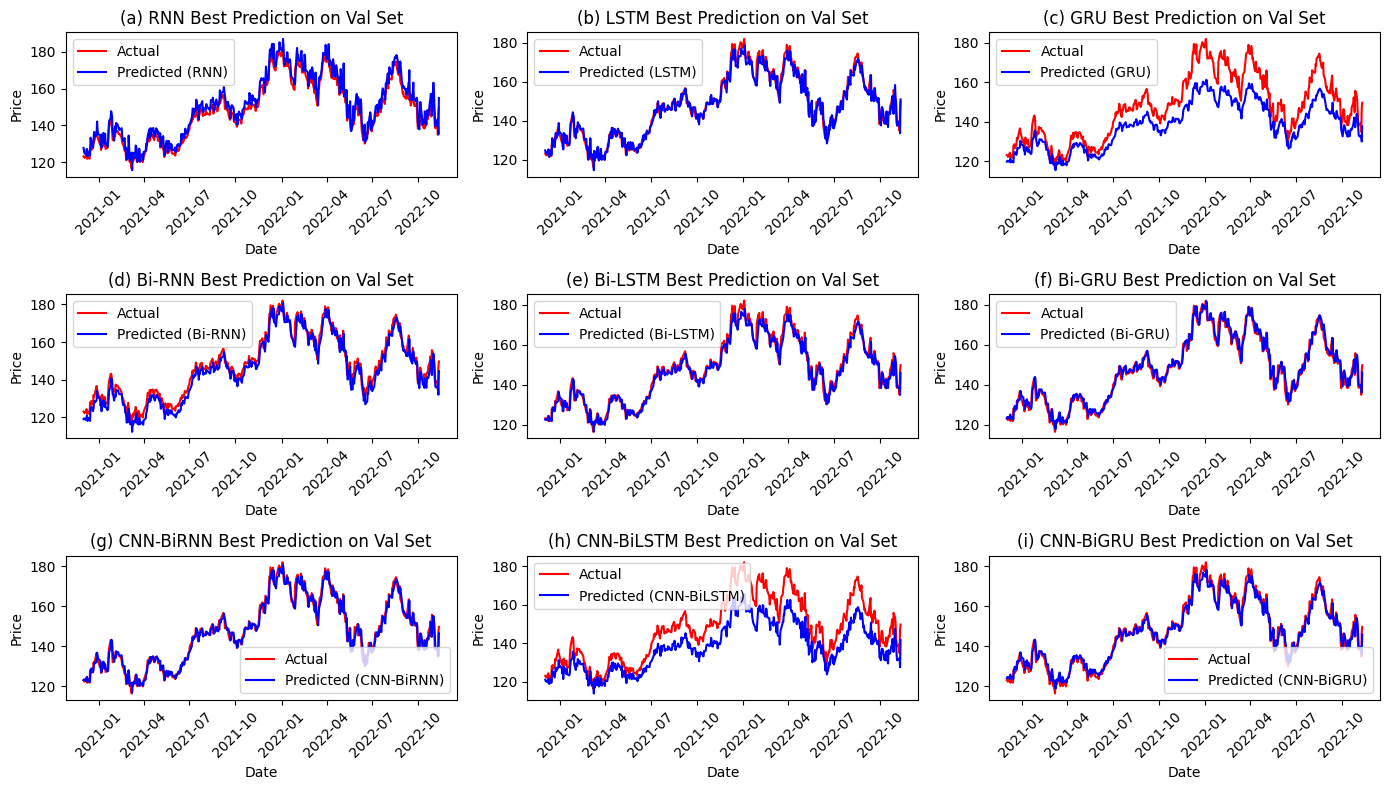

In [48]:
fig, axes = plt.subplots(3, 3, figsize=(14, 8))
axes = axes.flatten()
for i, info in enumerate(all_model_best_results):
    model_name = info['model_name']
    best_model = info['best_model']
    best_model.eval()
    val_preds = []
    with torch.no_grad():
        for j in range(len(X_val_t)):
            X_input = X_val_t[j].unsqueeze(0).to(device)
            pred = best_model(X_input).cpu().numpy()
            val_preds.append(pred[0][0])  # scalar
    val_preds = np.array(val_preds).reshape(-1,1)
    val_preds_inv = scaler.inverse_transform(val_preds)

    prefix = f"({chr(97+i)}) "
    axes[i].plot(val_dates, prices_val, label='Actual', color='red')
    axes[i].plot(val_dates, val_preds_inv, label=f'Predicted ({model_name})', color='blue')
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel('Price')
    axes[i].set_title(prefix + f'{model_name} Best Prediction on Val Set')
    axes[i].legend()
    for tick in axes[i].get_xticklabels():
        tick.set_rotation(45)

plt.tight_layout()
plt.show()

## Test

In [77]:
# Retrieve the best model's details from a sorted DataFrame
best_overall = df_all_sorted.iloc[2]
best_overall_model_name = best_overall['model']
best_overall_lr = best_overall['lr']
best_overall_optimizer = best_overall['optimizer']
best_overall_hidden_dim = best_overall['hidden_dim']
best_overall_num_layers = best_overall['num_layers']
# Display the best overall model parameters and evaluation metrics
print("Best Overall Model:", best_overall_model_name)
print("Best Overall Params:",
      "lr:", best_overall_lr,
      "optimizer:", best_overall_optimizer,
      "hidden_dim:", best_overall_hidden_dim,
      "num_layers:", best_overall_num_layers,
      "Val MSE:", best_overall['val_mse'],
      "Val MAPE:", best_overall['val_mape'],
      "Val R2:", best_overall['val_r2'])

Best Overall Model: CNN-BiRNN
Best Overall Params: lr: 0.001 optimizer: Adam hidden_dim: 128 num_layers: 1 Val MSE: 0.0002645841987032327 Val MAPE: 1.4581382274627686 Val R2: 0.9681778326630592


In [78]:
# Find the best overall model instance from the list of trained models
best_overall_info = [m for m in all_model_best_results if m['model_name'] == best_overall_model_name][0]
final_best_model = best_overall_info['best_model']

# Set the model to evaluation mode and predict on the test dataset
final_best_model.eval()
test_preds = []
with torch.no_grad():
    for i in range(len(X_test_t)):
        X_input = X_test_t[i].unsqueeze(0).to(device)
        pred = final_best_model(X_input).cpu().numpy()
        test_preds.append(pred[0][0])
# Convert the predictions array into a suitable format and inversely transform it to the original scale
test_preds = np.array(test_preds).reshape(-1,1)
test_preds_inv = scaler.inverse_transform(test_preds)
test_true_inv = scaler.inverse_transform(y_test)

test_true = y_test.reshape(-1,1)

# Calculate the normalized and denormalized Mean Squared Error (MSE)
test_mse_normal = np.mean((test_preds - test_true)**2)
test_mse = np.mean((test_preds_inv - test_true_inv)**2)

# Calculate the Mean Absolute Percentage Error (MAPE), adding epsilon to avoid division by zero errors
test_mape = np.mean(np.abs((test_true_inv - test_preds_inv) / test_true_inv)) * 100

# Calculate the coefficient of determination (R²)
ss_res = np.sum((test_true_inv - test_preds_inv)**2)
ss_tot = np.sum((test_true_inv - np.mean(test_true_inv))**2)
test_r2 = 1 - (ss_res / ss_tot)

# Print test evaluation metrics
print("Final Best Model Normalized Test MSE:", test_mse_normal)
print("Final Best Model Denormalized Test MSE:", test_mse)
print("Final Best Model Test MAPE:", test_mape, "%")
print("Final Best Model Test R²:", test_r2)

Final Best Model Normalized Test MSE: 0.00019695310329111214
Final Best Model Denormalized Test MSE: 6.282455366976272
Final Best Model Test MAPE: 1.226291586583103 %
Final Best Model Test R²: 0.9814251823387644


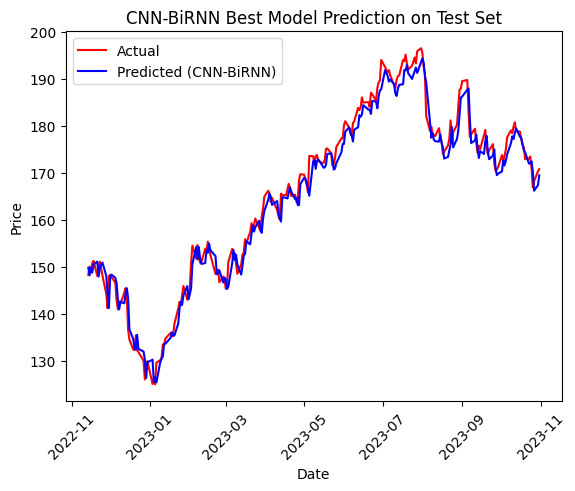

In [79]:
# Plot the actual vs predicted prices on the test dataset
plt.figure()
plt.plot(test_dates, test_true_inv, label='Actual', color='red')
plt.plot(test_dates, test_preds_inv, label=f'Predicted ({best_overall_model_name})', color='blue')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title(f'{best_overall_model_name} Best Model Prediction on Test Set')
plt.legend()
plt.xticks(rotation=45)
plt.show()